<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/fyp_model_training_GCC_part_1_and_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=e93ee10920dee79f3c510afbc931c8f6216bf8436d666b8a69434cafa85e98a7
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [4]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  | Proc size: 119.3 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [5]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
from sklearn.model_selection import train_test_split
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [7]:
import os
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    gt_path = img_path.replace('.png','.h5').replace('pngs','GT')
    img = Image.open(img_path).convert('RGB')
    gt_file = h5py.File(gt_path, 'r')
    target = np.asarray(gt_file['density'])
    target = cv2.resize(target,(int(target.shape[1]/2.25), int(target.shape[0]/2.25)),interpolation = cv2.INTER_CUBIC)*5.06448
    return img,target
"""
create a list of file (full directory)
"""

def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.png  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "pngs", "*.png"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    scences = ['scene_00_0','scene_00_1','scene_00_2','scene_00_1','scene_01_0','scene_01_1','scene_01_2','scene_01_3',
               'scene_02_0','scene_02_1','scene_02_2','scene_02_3','scene_03_0','scene_03_1','scene_03_2','scene_03_3',
               'scene_04_0','scene_04_1','scene_04_2','scene_04_3','scene_05_0','scene_05_1','scene_05_2','scene_05_3',
               'scene_06_0','scene_06_1','scene_06_2','scene_06_3','scene_07_0','scene_07_1','scene_07_2','scene_07_3',
               'scene_08_0','scene_08_1','scene_08_2','scene_08_3','scene_09_0','scene_09_1','scene_09_2','scene_09_3']
    image_path_list = []
    for scene in scences:
      image_path_list += glob.glob(os.path.join(DATA_PATH,scene, "pngs", "*.png"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val




class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, transform=None,  train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.transform = transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)
        
        #img = 255.0 * F.to_tensor(img)
        
        #img[0,:,:]=img[0,:,:]-92.8207477031
        #img[1,:,:]=img[1,:,:]-95.2757037428
        #img[2,:,:]=img[2,:,:]-104.877445883
        if self.transform is not None:
            img = self.transform(img)
            
        return img,target
  

In [8]:
class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [9]:
model = TestNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC/"+"Part"+" "+scene[7]+scene+"/"+"pngs/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("data size: ",len(train_list))
  return train_list



In [11]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part1_train_list = extract_image_path_list(train_list, "Part 1")
part0_train_list = extract_image_path_list(train_list, "Part 0")
print(len(part1_train_list) , len(part0_train_list))

data size:  1160
data size:  1320
1160 1320


In [12]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part1_test_list = extract_image_path_list(test_list, "Part 1")
part0_test_list = extract_image_path_list(test_list, "Part 0")

data size:  385
data size:  473


In [13]:
train_data = part1_train_list+ part0_train_list
len(train_data)

2480

In [14]:
test_data = part1_test_list+part0_test_list
len(test_data)

858

In [15]:
train_loader = torch.utils.data.DataLoader(ListDataset(train_data,
                                                                shuffle=True,
                                                                transform=transforms.Compose([
                                                                    transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [16]:
test_loader = torch.utils.data.DataLoader(ListDataset(test_data,
                                  shuffle=False,
                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480),transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                  std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                  ]), train=False,batch_size=2,num_workers=2),
              batch_size=2)

In [17]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
PATH = '/content/drive/MyDrive/GCC/TestNet_checkpoint_Part1_and_0.pth'
epoch = 5
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")

Successfully load the check point


In [23]:
print(epoch , start_epoch)

5 4


In [28]:
#PATH = '/content/drive/MyDrive/GCC/TestNet_checkpoint_Part1_1.pth'

In [24]:
for epoch in range(start_epoch,epoch):
    mae_train = 0
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    model.train()
    end = time.time()
    loss_list = []
    mae_list =[]
    best_predict_mae = 2000
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img)

        output = model(img)
        target = target.type(torch.FloatTensor).unsqueeze(1).cuda()
        target = Variable(target)


        #backword
        loss = criterion(output, target)
        losses.update(loss.item(), img.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()


        #calculate the MAE values
        pred_map = output.data.cpu().numpy()
        gt_map = target.data.cpu().numpy()
        mae_train += abs(np.sum(pred_map) -np.sum(gt_map))

        if i % 50 == 0:
            print('Epoch : {}, train MAE : {}'.format(epoch, mae_train/len(train_loader)))
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                .format(
                epoch, i, len(train_loader), batch_time=batch_time,
                data_time=data_time, loss=losses))
    
    scheduler.step()  
    mae_list.append(mae_train / len(train_loader))
    loss_list.append(loss)
    mae_train = mae_train / len(train_loader)
    print(' * TRAINING MAE {mae:.3f} '.format(mae=mae_train)) 
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH) 
    print("testing...................")  
    with torch.no_grad():
      model.eval()
      mae_test = 0

      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output = model(img_test)


          pred_map = output.data.cpu().numpy()
          gt_map = target_test.data.cpu().numpy()
          #print("Model Predicted Count", np.sum(pred_map))
          #print("Ground Trueth Count", np.sum(gt_map))

          mae_test += abs(np.sum(pred_map) -np.sum(gt_map))

      mae_test = mae_test / len(test_loader)
      print(' * TESTING MAE {mae:.3f} '.format(mae=mae_test))



MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC/GCC_part1_and_0.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch : 4, train MAE : 0.31923665692729336
Epoch: [4][0/1240]	Time 8.794 (8.794)	Data 0.000 (0.000)	Loss 12.6315 (12.6315)	
Epoch : 4, train MAE : 18.418969991130215
Epoch: [4][50/1240]	Time 7.329 (7.129)	Data 0.000 (0.000)	Loss 4.3101 (149.2827)	
Epoch : 4, train MAE : 40.33840501231532
Epoch: [4][100/1240]	Time 6.507 (6.633)	Data 0.000 (0.000)	Loss 343.8561 (118.3132)	
Epoch : 4, train MAE : 56.02479162523824
Epoch: [4][150/1240]	Time 5.961 (6.400)	Data 0.000 (0.000)	Loss 3123.1108 (131.8921)	
Epoch : 4, train MAE : 85.81549333756969
Epoch: [4][200/1240]	Time 5.620 (6.275)	Data 0.000 (0.000)	Loss 3.4920 (166.6701)	
Epoch : 4, train MAE : 113.28662140753961
Epoch: [4][250/1240]	Time 6.519 (6.260)	Data 0.000 (0.000)	Loss 96.7743 (163.5326)	
Epoch : 4, train MAE : 132.83990116119384
Epoch: [4][300/1240]	Time 5.737 (6.232)	Data 0.000 (0.000)	Loss 214.7664 (163.6187)	
Epoch : 4, train MAE : 164.69643952769619
Epoch: [4][350/1240]	Time 5.727 (6.182)	Data 0.000 (0.000)	Loss 5.1162 (167.8977

In [ ]:
Epoch : 0, train MAE : 55.19919354838709
Epoch: [0][0/1240]	Time 7.483 (7.483)	Data 0.000 (0.000)	Loss 5748.2646 (5748.2646)	
Epoch : 0, train MAE : 852.6024896929341
Epoch: [0][50/1240]	Time 5.227 (6.060)	Data 0.000 (0.000)	Loss 103.0509 (1626.4092)	
Epoch : 0, train MAE : 917.640544503735
Epoch: [0][100/1240]	Time 5.223 (5.749)	Data 0.000 (0.000)	Loss 1194.4203 (947.4366)	
Epoch : 0, train MAE : 990.6384163456578
Epoch: [0][150/1240]	Time 5.962 (5.691)	Data 0.000 (0.000)	Loss 38.2241 (739.8571)	
Epoch : 0, train MAE : 1034.2503422214138
Epoch: [0][200/1240]	Time 4.902 (5.602)	Data 0.000 (0.000)	Loss 47.0679 (617.7378)	
Epoch : 0, train MAE : 1092.2179851224346
Epoch: [0][250/1240]	Time 5.328 (5.543)	Data 0.000 (0.000)	Loss 894.4631 (563.5702)	
Epoch : 0, train MAE : 1133.2624096470495
Epoch: [0][300/1240]	Time 4.779 (5.499)	Data 0.000 (0.000)	Loss 31.9384 (501.8842)	
Epoch : 0, train MAE : 1171.8969173615978
Epoch: [0][350/1240]	Time 5.283 (5.494)	Data 0.000 (0.000)	Loss 57.9551 (470.6151)	
Epoch : 0, train MAE : 1221.614721784284
Epoch: [0][400/1240]	Time 5.930 (5.463)	Data 0.000 (0.000)	Loss 25.6853 (467.6957)	
Epoch : 0, train MAE : 1273.1384700344454
Epoch: [0][450/1240]	Time 4.862 (5.438)	Data 0.000 (0.000)	Loss 57.7847 (427.9854)	
Epoch : 0, train MAE : 1313.1089428993964
Epoch: [0][500/1240]	Time 5.076 (5.430)	Data 0.000 (0.000)	Loss 38.7730 (401.0213)	
Epoch : 0, train MAE : 1352.767872053577
Epoch: [0][550/1240]	Time 4.952 (5.416)	Data 0.000 (0.000)	Loss 35.1289 (373.3717)	
Epoch : 0, train MAE : 1388.056735469449
Epoch: [0][600/1240]	Time 5.461 (5.408)	Data 0.000 (0.000)	Loss 10.3722 (355.2682)	
Epoch : 0, train MAE : 1417.0140192831716
Epoch: [0][650/1240]	Time 5.545 (5.428)	Data 0.000 (0.000)	Loss 17.9120 (347.8519)	
Epoch : 0, train MAE : 1460.963979191934
Epoch: [0][700/1240]	Time 5.636 (5.461)	Data 0.000 (0.000)	Loss 24.2806 (352.1758)	
Epoch : 0, train MAE : 1508.2847310343097
Epoch: [0][750/1240]	Time 4.956 (5.483)	Data 0.000 (0.000)	Loss 3914.6992 (346.1710)	
Epoch : 0, train MAE : 1544.8176080211517
Epoch: [0][800/1240]	Time 6.767 (5.492)	Data 0.000 (0.000)	Loss 74.2183 (337.0618)	
Epoch : 0, train MAE : 1593.4806328988843
Epoch: [0][850/1240]	Time 5.425 (5.536)	Data 0.000 (0.000)	Loss 10.0556 (332.1420)	
Epoch : 0, train MAE : 1630.7566438428817
Epoch: [0][900/1240]	Time 8.437 (5.569)	Data 0.000 (0.000)	Loss 226.6070 (331.2965)	
Epoch : 0, train MAE : 1660.3512325594502
Epoch: [0][950/1240]	Time 5.654 (5.622)	Data 0.000 (0.000)	Loss 64.8112 (320.2268)	
Epoch : 0, train MAE : 1714.841304563707
Epoch: [0][1000/1240]	Time 5.582 (5.626)	Data 0.000 (0.000)	Loss 29.5990 (317.4911)	
Epoch : 0, train MAE : 1743.9901980923069
Epoch: [0][1050/1240]	Time 5.334 (5.630)	Data 0.000 (0.000)	Loss 92.2275 (313.1643)	
Epoch : 0, train MAE : 1790.6141339086716
Epoch: [0][1100/1240]	Time 6.362 (5.617)	Data 0.000 (0.000)	Loss 15.1559 (306.9900)	
Epoch : 0, train MAE : 1831.0070704552436
Epoch: [0][1150/1240]	Time 6.741 (5.614)	Data 0.000 (0.000)	Loss 64.4200 (303.9920)	
Epoch : 0, train MAE : 1852.993307685852
Epoch: [0][1200/1240]	Time 4.976 (5.615)	Data 0.000 (0.000)	Loss 10.7286 (298.8758)	
 * TRAINING MAE 1877.258 
testing...................
 * TESTING MAE 1401.935 
Epoch : 1, train MAE : 1.4488512592930947
Epoch: [1][0/1240]	Time 4.730 (4.730)	Data 0.000 (0.000)	Loss 11.6312 (11.6312)	
Epoch : 1, train MAE : 24.490287067044164
Epoch: [1][50/1240]	Time 4.802 (4.881)	Data 0.000 (0.000)	Loss 8.0936 (121.9286)	
Epoch : 1, train MAE : 41.23081428773941
Epoch: [1][100/1240]	Time 4.717 (4.891)	Data 0.000 (0.000)	Loss 975.6016 (135.6587)	
Epoch : 1, train MAE : 78.31475694717899
Epoch: [1][150/1240]	Time 4.910 (4.918)	Data 0.000 (0.000)	Loss 12.7642 (161.5851)	
Epoch : 1, train MAE : 103.52365432247039
Epoch: [1][200/1240]	Time 4.933 (4.991)	Data 0.000 (0.000)	Loss 21.4074 (168.2975)	
Epoch : 1, train MAE : 131.93182971092963
Epoch: [1][250/1240]	Time 5.146 (4.970)	Data 0.000 (0.000)	Loss 799.2885 (186.6207)	
Epoch : 1, train MAE : 157.04746919755013
Epoch: [1][300/1240]	Time 4.904 (4.956)	Data 0.000 (0.000)	Loss 14.3793 (180.4964)	
Epoch : 1, train MAE : 183.92740937817481
Epoch: [1][350/1240]	Time 5.074 (4.945)	Data 0.000 (0.000)	Loss 31.3365 (189.6012)	
Epoch : 1, train MAE : 223.5028989514997
Epoch: [1][400/1240]	Time 5.327 (4.935)	Data 0.000 (0.000)	Loss 7.2315 (210.7644)	
Epoch : 1, train MAE : 244.27852350973313
Epoch: [1][450/1240]	Time 4.695 (4.918)	Data 0.000 (0.000)	Loss 43.8185 (196.8113)	
Epoch : 1, train MAE : 277.5475949656579
Epoch: [1][500/1240]	Time 4.876 (4.905)	Data 0.000 (0.000)	Loss 25.0531 (191.3402)	
Epoch : 1, train MAE : 298.8173779979829
Epoch: [1][550/1240]	Time 4.742 (4.907)	Data 0.000 (0.000)	Loss 25.7380 (181.3961)	
Epoch : 1, train MAE : 322.76676898156444
Epoch: [1][600/1240]	Time 4.627 (4.898)	Data 0.000 (0.000)	Loss 3.8154 (177.7004)	
Epoch : 1, train MAE : 351.7561847225312
Epoch: [1][650/1240]	Time 4.767 (4.889)	Data 0.000 (0.000)	Loss 12.3657 (182.2655)	
Epoch : 1, train MAE : 378.5593618239126
Epoch: [1][700/1240]	Time 4.896 (4.880)	Data 0.000 (0.000)	Loss 8.6694 (193.4600)	
Epoch : 1, train MAE : 407.680486952874
Epoch: [1][750/1240]	Time 4.698 (4.874)	Data 0.000 (0.000)	Loss 3425.5991 (195.2192)	
Epoch : 1, train MAE : 430.9532913300299
Epoch: [1][800/1240]	Time 4.912 (4.888)	Data 0.000 (0.000)	Loss 64.6777 (194.5996)	
Epoch : 1, train MAE : 462.57594729700395
Epoch: [1][850/1240]	Time 5.017 (4.885)	Data 0.000 (0.000)	Loss 5.9131 (196.8220)	
Epoch : 1, train MAE : 502.9935871954887
Epoch: [1][900/1240]	Time 4.898 (4.882)	Data 0.000 (0.000)	Loss 205.0820 (200.6584)	
Epoch : 1, train MAE : 527.2897692741886
Epoch: [1][950/1240]	Time 4.650 (4.878)	Data 0.000 (0.000)	Loss 59.8263 (195.9166)	
Epoch : 1, train MAE : 564.1090869872801
Epoch: [1][1000/1240]	Time 4.597 (4.874)	Data 0.000 (0.000)	Loss 23.5842 (197.7861)	
Epoch : 1, train MAE : 585.9070896487082
Epoch: [1][1050/1240]	Time 4.965 (4.883)	Data 0.000 (0.000)	Loss 90.8673 (198.3018)	
Epoch : 1, train MAE : 624.978376114753
Epoch: [1][1100/1240]	Time 5.015 (4.885)	Data 0.000 (0.000)	Loss 5.9274 (197.9236)	
Epoch : 1, train MAE : 662.786581793139
Epoch: [1][1150/1240]	Time 5.292 (4.902)	Data 0.000 (0.000)	Loss 63.0526 (200.0688)	
Epoch : 1, train MAE : 705.8899679030142
Epoch: [1][1200/1240]	Time 4.650 (4.920)	Data 0.000 (0.000)	Loss 12.1624 (200.2637)	
 * TRAINING MAE 734.044 
testing...................
 * TESTING MAE 898.933 
Epoch : 2, train MAE : 0.636878425844254
Epoch: [2][0/1240]	Time 4.950 (4.950)	Data 0.000 (0.000)	Loss 6.8375 (6.8375)	
Epoch : 2, train MAE : 22.83502906060988
Epoch: [2][50/1240]	Time 5.429 (4.874)	Data 0.000 (0.000)	Loss 5.2442 (114.8793)	
Epoch : 2, train MAE : 36.718053639319635
Epoch: [2][100/1240]	Time 4.591 (5.001)	Data 0.000 (0.000)	Loss 978.4174 (128.1796)	
Epoch : 2, train MAE : 67.32520192669284
Epoch: [2][150/1240]	Time 4.630 (4.945)	Data 0.000 (0.000)	Loss 8.8736 (151.7119)	
Epoch : 2, train MAE : 99.88021399590276
Epoch: [2][200/1240]	Time 4.696 (4.918)	Data 0.000 (0.000)	Loss 18.4256 (157.8583)	
Epoch : 2, train MAE : 122.53045162693147
Epoch: [2][250/1240]	Time 5.010 (4.937)	Data 0.000 (0.000)	Loss 813.6854 (176.8351)	
Epoch : 2, train MAE : 139.66466541290282
Epoch: [2][300/1240]	Time 5.443 (4.932)	Data 0.000 (0.000)	Loss 11.5237 (169.5188)	
Epoch : 2, train MAE : 161.08400666636805
Epoch: [2][350/1240]	Time 4.938 (4.944)	Data 0.000 (0.000)	Loss 27.6702 (177.4962)	
Epoch : 2, train MAE : 191.7138799421249
Epoch: [2][400/1240]	Time 4.701 (4.933)	Data 0.000 (0.000)	Loss 4.3892 (197.4289)	
Epoch : 2, train MAE : 212.61901251269924
Epoch: [2][450/1240]	Time 4.970 (4.917)	Data 0.000 (0.000)	Loss 41.0898 (184.3051)	
Epoch : 2, train MAE : 231.02994980350618
Epoch: [2][500/1240]	Time 4.892 (4.907)	Data 0.000 (0.000)	Loss 19.6582 (178.2140)	
Epoch : 2, train MAE : 243.9969623565674
Epoch: [2][550/1240]	Time 5.428 (4.924)	Data 0.000 (0.000)	Loss 22.5502 (168.8126)	
Epoch : 2, train MAE : 259.40305381282684
Epoch: [2][600/1240]	Time 4.869 (4.925)	Data 0.000 (0.000)	Loss 2.8318 (165.2621)	
Epoch : 2, train MAE : 282.926054972987
Epoch: [2][650/1240]	Time 4.974 (4.925)	Data 0.000 (0.000)	Loss 10.0549 (169.9211)	
Epoch : 2, train MAE : 309.52590418169575
Epoch: [2][700/1240]	Time 5.414 (5.013)	Data 0.000 (0.000)	Loss 8.5142 (180.7679)	
Epoch : 2, train MAE : 326.04406364194807
Epoch: [2][750/1240]	Time 5.416 (5.113)	Data 0.000 (0.000)	Loss 3248.2900 (182.6134)	
Epoch : 2, train MAE : 347.97969750435124
Epoch: [2][800/1240]	Time 4.728 (5.114)	Data 0.000 (0.000)	Loss 58.6035 (181.8954)	
Epoch : 2, train MAE : 381.1895760997649
Epoch: [2][850/1240]	Time 4.664 (5.097)	Data 0.000 (0.000)	Loss 3.1804 (184.3792)	
Epoch : 2, train MAE : 436.579195631704
Epoch: [2][900/1240]	Time 4.686 (5.084)	Data 0.000 (0.000)	Loss 198.9725 (188.8516)	
Epoch : 2, train MAE : 470.0181202857725
Epoch: [2][950/1240]	Time 4.749 (5.073)	Data 0.000 (0.000)	Loss 53.3257 (184.5522)	
Epoch : 2, train MAE : 494.44385495954947
Epoch: [2][1000/1240]	Time 4.661 (5.062)	Data 0.000 (0.000)	Loss 21.6961 (186.4316)	
Epoch : 2, train MAE : 514.1493231804141
Epoch: [2][1050/1240]	Time 4.727 (5.060)	Data 0.000 (0.000)	Loss 79.5737 (186.7659)	
Epoch : 2, train MAE : 531.3065292235343
Epoch: [2][1100/1240]	Time 5.551 (5.076)	Data 0.000 (0.000)	Loss 3.8912 (185.3817)	
Epoch : 2, train MAE : 555.6737666345412
Epoch: [2][1150/1240]	Time 4.811 (5.072)	Data 0.000 (0.000)	Loss 60.5976 (186.5245)	
Epoch : 2, train MAE : 577.9391820415374
Epoch: [2][1200/1240]	Time 4.979 (5.063)	Data 0.000 (0.000)	Loss 7.4184 (185.5598)	
 * TRAINING MAE 590.714 
testing...................
 * TESTING MAE 1083.754 
Epoch : 3, train MAE : 1.0651937177104334
Epoch: [3][0/1240]	Time 4.929 (4.929)	Data 0.000 (0.000)	Loss 6.8908 (6.8908)	
Epoch : 3, train MAE : 17.677543270972468
Epoch: [3][50/1240]	Time 4.777 (4.896)	Data 0.000 (0.000)	Loss 3.4884 (106.8264)	
Epoch : 3, train MAE : 31.838948243664156
Epoch: [3][100/1240]	Time 4.840 (4.865)	Data 0.000 (0.000)	Loss 885.8696 (120.0715)	
Epoch : 3, train MAE : 51.72515742394232
Epoch: [3][150/1240]	Time 4.960 (4.986)	Data 0.000 (0.000)	Loss 4.8628 (141.8766)	
Epoch : 3, train MAE : 75.79026859652612
Epoch: [3][200/1240]	Time 5.424 (5.352)	Data 0.000 (0.000)	Loss 16.2880 (147.1772)	
Epoch : 3, train MAE : 97.53350544591103
Epoch: [3][250/1240]	Time 5.109 (5.280)	Data 0.000 (0.000)	Loss 748.6597 (166.1311)	
Epoch : 3, train MAE : 115.5017034099948
Epoch: [3][300/1240]	Time 4.760 (5.214)	Data 0.000 (0.000)	Loss 10.3961 (159.2459)	
Epoch : 3, train MAE : 139.27312497785013
Epoch: [3][350/1240]	Time 4.984 (5.169)	Data 0.000 (0.000)	Loss 26.3337 (168.0276)	
Epoch : 3, train MAE : 177.32684153895224
Epoch: [3][400/1240]	Time 4.819 (5.121)	Data 0.000 (0.000)	Loss 2.4690 (188.7351)	
Epoch : 3, train MAE : 199.77020324583975
Epoch: [3][450/1240]	Time 5.642 (5.095)	Data 0.000 (0.000)	Loss 37.5841 (175.9871)	
Epoch : 3, train MAE : 215.7237505082161
Epoch: [3][500/1240]	Time 12.454 (5.378)	Data 0.000 (0.000)	Loss 17.2503 (170.2911)	
Epoch : 3, train MAE : 229.54453998073456
Epoch: [3][550/1240]	Time 6.430 (5.525)	Data 0.000 (0.000)	Loss 20.8515 (161.1218)	
Epoch : 3, train MAE : 238.98270445177633
Epoch: [3][600/1240]	Time 5.408 (5.538)	Data 0.000 (0.000)	Loss 1.7944 (157.5129)	
Epoch : 3, train MAE : 253.76815315369637
Epoch: [3][650/1240]	Time 4.971 (5.504)	Data 0.000 (0.000)	Loss 9.2876 (161.8450)	
Epoch : 3, train MAE : 285.3951905773532
Epoch: [3][700/1240]	Time 4.859 (5.460)	Data 0.000 (0.000)	Loss 17.5677 (172.8759)	
Epoch : 3, train MAE : 310.25364594305717
Epoch: [3][750/1240]	Time 5.064 (5.420)	Data 0.000 (0.000)	Loss 3484.8577 (175.7615)	
Epoch : 3, train MAE : 333.97874823847127
Epoch: [3][800/1240]	Time 4.785 (5.399)	Data 0.000 (0.000)	Loss 57.1773 (175.1710)	
Epoch : 3, train MAE : 366.32652451607487
Epoch: [3][850/1240]	Time 4.822 (5.368)	Data 0.000 (0.000)	Loss 3.4630 (177.7177)	
Epoch : 3, train MAE : 392.15236250046763
Epoch: [3][900/1240]	Time 4.711 (5.342)	Data 0.000 (0.000)	Loss 182.8148 (181.8310)	
Epoch : 3, train MAE : 420.45711717605593
Epoch: [3][950/1240]	Time 4.732 (5.316)	Data 0.000 (0.000)	Loss 51.0711 (177.5709)	
Epoch : 3, train MAE : 441.160400215272
Epoch: [3][1000/1240]	Time 5.411 (5.355)	Data 0.000 (0.000)	Loss 24.9457 (179.7176)	
Epoch : 3, train MAE : 478.48554809016565
Epoch: [3][1050/1240]	Time 4.930 (5.334)	Data 0.000 (0.000)	Loss 73.1971 (180.7197)	
Epoch : 3, train MAE : 507.1688440230585
Epoch: [3][1100/1240]	Time 6.412 (5.316)	Data 0.000 (0.000)	Loss 3.1221 (179.2920)	
Epoch : 3, train MAE : 527.1996144663904
Epoch: [3][1150/1240]	Time 5.064 (5.335)	Data 0.000 (0.000)	Loss 57.0752 (180.2040)	
Epoch : 3, train MAE : 548.4569445148591
Epoch: [3][1200/1240]	Time 5.027 (5.354)	Data 0.000 (0.000)	Loss 6.6205 (179.3493)	
 * TRAINING MAE 560.158 
testing...................
 * TESTING MAE 629.718 
 Epoch : 4, train MAE : 0.31923665692729336
Epoch: [4][0/1240]	Time 8.794 (8.794)	Data 0.000 (0.000)	Loss 12.6315 (12.6315)	
Epoch : 4, train MAE : 18.418969991130215
Epoch: [4][50/1240]	Time 7.329 (7.129)	Data 0.000 (0.000)	Loss 4.3101 (149.2827)	
Epoch : 4, train MAE : 40.33840501231532
Epoch: [4][100/1240]	Time 6.507 (6.633)	Data 0.000 (0.000)	Loss 343.8561 (118.3132)	
Epoch : 4, train MAE : 56.02479162523824
Epoch: [4][150/1240]	Time 5.961 (6.400)	Data 0.000 (0.000)	Loss 3123.1108 (131.8921)	
Epoch : 4, train MAE : 85.81549333756969
Epoch: [4][200/1240]	Time 5.620 (6.275)	Data 0.000 (0.000)	Loss 3.4920 (166.6701)	
Epoch : 4, train MAE : 113.28662140753961
Epoch: [4][250/1240]	Time 6.519 (6.260)	Data 0.000 (0.000)	Loss 96.7743 (163.5326)	
Epoch : 4, train MAE : 132.83990116119384
Epoch: [4][300/1240]	Time 5.737 (6.232)	Data 0.000 (0.000)	Loss 214.7664 (163.6187)	
Epoch : 4, train MAE : 164.69643952769619
Epoch: [4][350/1240]	Time 5.727 (6.182)	Data 0.000 (0.000)	Loss 5.1162 (167.8977)	
Epoch : 4, train MAE : 183.16857813558272
Epoch: [4][400/1240]	Time 5.629 (6.145)	Data 0.000 (0.000)	Loss 11.6012 (175.1188)	
Epoch : 4, train MAE : 201.76928015062887
Epoch: [4][450/1240]	Time 6.016 (6.138)	Data 0.000 (0.000)	Loss 4.3488 (175.7710)	
Epoch : 4, train MAE : 222.1367035958075
Epoch: [4][500/1240]	Time 5.684 (6.115)	Data 0.000 (0.000)	Loss 1156.5968 (177.0673)	
Epoch : 4, train MAE : 263.239496397203
Epoch: [4][550/1240]	Time 6.229 (6.090)	Data 0.000 (0.000)	Loss 3005.6106 (193.3320)	
Epoch : 4, train MAE : 304.2390642996757
Epoch: [4][600/1240]	Time 5.560 (6.068)	Data 0.000 (0.000)	Loss 444.2254 (188.2160)	
Epoch : 4, train MAE : 333.42803490238805
Epoch: [4][650/1240]	Time 5.533 (6.050)	Data 0.000 (0.000)	Loss 9.4480 (193.9178)	
Epoch : 4, train MAE : 360.7168179635079
Epoch: [4][700/1240]	Time 5.573 (6.037)	Data 0.000 (0.000)	Loss 12.7270 (196.2265)	
Epoch : 4, train MAE : 387.8923954963684
Epoch: [4][750/1240]	Time 5.972 (6.024)	Data 0.000 (0.000)	Loss 8.5204 (195.5001)	
Epoch : 4, train MAE : 406.5415244410115
Epoch: [4][800/1240]	Time 6.017 (6.015)	Data 0.000 (0.000)	Loss 18.4432 (196.8844)	
Epoch : 4, train MAE : 424.5048793269742
Epoch: [4][850/1240]	Time 5.667 (6.010)	Data 0.000 (0.000)	Loss 13.9754 (191.4631)	
Epoch : 4, train MAE : 440.66224894523623
Epoch: [4][900/1240]	Time 6.183 (6.008)	Data 0.000 (0.000)	Loss 56.9246 (188.8205)	
Epoch : 4, train MAE : 473.6384720110124
Epoch: [4][950/1240]	Time 5.918 (6.005)	Data 0.000 (0.000)	Loss 4.5481 (185.2493)	
Epoch : 4, train MAE : 486.50849445250725
Epoch: [4][1000/1240]	Time 6.107 (6.003)	Data 0.000 (0.000)	Loss 738.9613 (183.6046)	
Epoch : 4, train MAE : 501.6477120014929
Epoch: [4][1050/1240]	Time 5.774 (5.995)	Data 0.000 (0.000)	Loss 2.2886 (182.3595)	
Epoch : 4, train MAE : 511.8334217763716
Epoch: [4][1100/1240]	Time 5.612 (5.989)	Data 0.000 (0.000)	Loss 67.0259 (179.9877)	
Epoch : 4, train MAE : 532.5975094841373
Epoch: [4][1150/1240]	Time 5.788 (5.986)	Data 0.000 (0.000)	Loss 13.8711 (182.5813)	
Epoch : 4, train MAE : 558.6974120616912
Epoch: [4][1200/1240]	Time 5.620 (5.992)	Data 0.000 (0.000)	Loss 1.5106 (177.9800)	
 * TRAINING MAE 571.861 
testing...................
 * TESTING MAE 322.011 

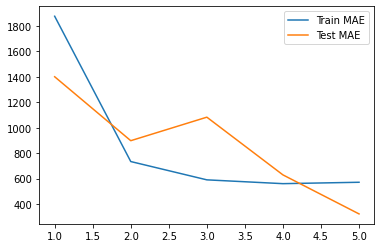

In [26]:
import matplotlib.pyplot as plt
import numpy as np

x1 = [1,2,3,4,5]
y1 = [1877,734,590,560,571]
y2 = [1401,898,1083,629,322]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])

In [17]:
model_path = '/content/drive/MyDrive/GCC/GCC_part0.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))
print('successfully load model from', model_path)


with torch.no_grad():
  model.eval()
  mae = 0

  for i, (img, target) in enumerate(test_loader):
      img = img.cuda()
      img = Variable(img)   
      output = model(img)


      pred_map = output.data.cpu().numpy()
      gt_map = target.data.cpu().numpy()
      print("Model Predicted Count", np.sum(pred_map))
      print("Ground Trueth Count", np.sum(gt_map))

      mae += abs(np.sum(pred_map) -np.sum(gt_map))

  mae = mae / len(test_loader)
  print(' * TESTING MAE {mae:.3f} '.format(mae=mae))

successfully load model from /content/drive/MyDrive/GCC/GCC_part0.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Model Predicted Count 500.09497
Ground Trueth Count 142.75102
Model Predicted Count 502.30704
Ground Trueth Count 160.72224
Model Predicted Count 589.12366
Ground Trueth Count 326.9262
Model Predicted Count 580.8849
Ground Trueth Count 430.48
Model Predicted Count 576.3402
Ground Trueth Count 280.38525
Model Predicted Count 481.88925
Ground Trueth Count 151.05339
Model Predicted Count 472.04752
Ground Trueth Count 168.16994
Model Predicted Count 461.20496
Ground Trueth Count 72.14069
Model Predicted Count 453.50922
Ground Trueth Count 25.0146
Model Predicted Count 538.34204
Ground Trueth Count 211.46396
Model Predicted Count 594.0167
Ground Trueth Count 304.09363
Model Predicted Count 505.31146
Ground Trueth Count 160.05145
Model Predicted Count 572.9192
Ground Trueth Count 278.636
Model Predicted Count 510.06976
Ground Trueth Count 144.24098
Model Predicted Count 610.1304
Ground Trueth Count 347.47336
Model Predicted Count 711.5775
Ground Trueth Count 429.54706
Model Predicted Count 5

In [16]:
model_path = '/content/drive/MyDrive/GCC/GCC_part1.pth'

model = TestNet().cuda()
# load the trained model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

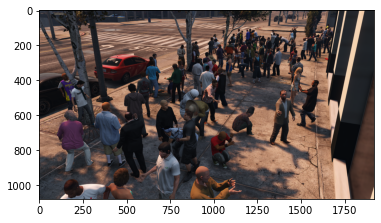

In [33]:
img_path = "/content/drive/MyDrive/GCC/Part 1/scene_11_3/pngs/1531175876.png"
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import PIL.Image as Image
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_path))

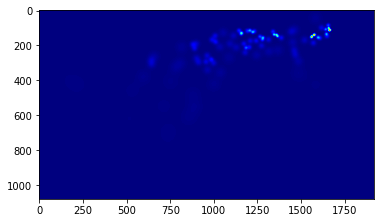

In [18]:
density_map_path = "/content/drive/MyDrive/GCC/Part 1/scene_11_3/GT/1531175876.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [19]:
np.sum(groundtruth)

97.45222

In [34]:
im = Image.open(img_path)

In [35]:
pred_transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(480), transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                                                std=[0.227743327618, 0.211051672697, 0.184846073389]),])



In [36]:
pred = model(pred_transform(im)[None].cuda())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


In [37]:
pred = pred.cpu()
pred = pred.detach().numpy()
np.sum(pred)

47.453293

In [53]:
groundtruth

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 5.2409831e-08,
        5.1109467e-08, 4.9818805e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.8516796e-08,
        4.7313019e-08, 4.6118231e-08],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.4892605e-08,
        4.3778751e-08, 4.2673211e-08]], dtype=float32)

In [28]:
pred

array([[[[-7.8019500e-04, -2.0230599e-03,  4.4647232e-04, ...,
           4.7590584e-04,  6.6462159e-04,  1.1260025e-03],
         [-2.3263320e-04, -3.1499118e-03, -1.8489361e-03, ...,
           6.5013766e-05, -3.7603080e-05,  2.7125701e-04],
         [-2.4316758e-03, -2.7776361e-03,  5.4773688e-04, ...,
          -1.3004094e-03,  1.7546117e-06, -2.3927167e-04],
         ...,
         [ 2.7009845e-04, -8.9921057e-05,  2.8686225e-04, ...,
          -1.4900044e-04,  4.3500215e-04, -4.1076913e-04],
         [-7.7561662e-04, -4.0296465e-05, -1.5193559e-03, ...,
           4.8356503e-04,  2.2669137e-04,  1.4295317e-03],
         [-7.4265897e-04, -7.0674717e-04, -1.9681081e-03, ...,
           2.6847795e-04,  9.7564608e-04,  1.4027841e-03]]]],
      dtype=float32)

2370.8547

In [ ]:
#cv2.imwrite('pred4.jpg',groundtruth)

True

In [24]:
import matplotlib

matplotlib.image.imsave('pred2.png', pred[0][0])

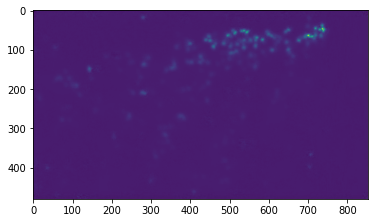

In [25]:
import matplotlib.pyplot as plt
img_path = "./pred2.png"
im = Image.open(img_path)
plt.imshow(im,cmap=CM.jet)

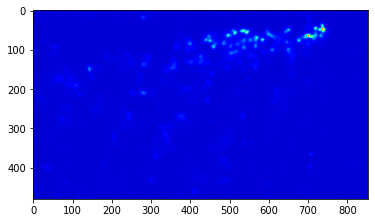

In [26]:
 
#im =  np.asarray(im)
plt.imshow(pred[0][0],cmap=CM.jet)

## ShanghaiTech Testing

In [45]:
sh_im = Image.open('/content/drive/MyDrive/Model_Test_Data/PartA/test_data/images/IMG_1.jpg')
sh_pred = model(pred_transform(sh_im)[None].cuda())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


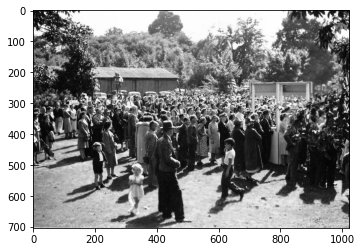

In [46]:
#now see a sample from ShanghaiA
plt.imshow(sh_im)

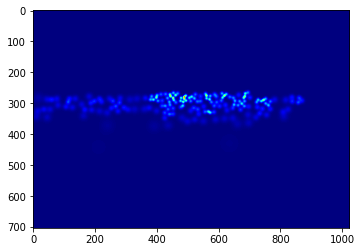

In [47]:
density_map_path = "/content/drive/MyDrive/Model_Test_Data/PartA/test_data/ground-truth-h5/IMG_1.h5"
import h5py
gt_file = h5py.File(density_map_path,'r')
groundtruth = np.asarray(gt_file['density'])

plt.imshow(groundtruth,cmap=CM.jet)

In [48]:
round(np.sum(groundtruth))

172

In [49]:
sh_pred = sh_pred.cpu()
sh_pred = sh_pred.detach().numpy()
round(np.sum(sh_pred))

183

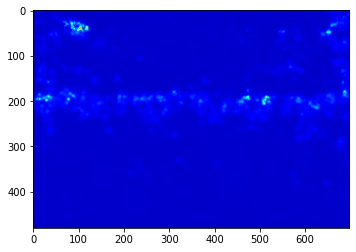

In [51]:
plt.imshow(sh_pred[0][0],cmap=CM.jet)

In [54]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()


Gen RAM Free: 25.5 GB  | Proc size: 3.7 GB
GPU RAM Free: 15047MB | Used: 1233MB | Util   8% | Total 16280MB


In [53]:
import torch, gc
#with torch.no_grad():
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  310864 KB |    8212 MB |   30700 MB |   30396 MB |\n|       from large pool |  297600 KB |    8198 MB |   30639 MB |   30348 MB |\n|       from small pool |   13264 KB |      19 MB |      61 MB |      48 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  310864 KB |    8212 MB |   30700 MB |   30396 MB |\n|       from large pool |  297600 KB |    8198 MB |